# Parameter choice

This notebook demonstrates how the function parameterBounds_MaxCut handles symmetries in gamma and beta to select appropriate bounds.

First do some imports and define handy plotting functions.

In [1]:
from qiskit import *
import numpy as np
import pylab as pl
import networkx as nx
from qiskit.visualization import *
from qiskit.providers.aer.noise import NoiseModel
from qaoa import *
from pylab import cm

from matplotlib import rc,patches
from scipy import optimize as opt

SAMPLING_E_ATOL = 5e-2
SAMPLING_E_RTOL = 1e-2
SAMPLING_DELTA_V_RTOL = 1e-1
MIN_SAMPLES = 256
MAX_SAMPLES = 32768*2*2
SAMPLING_CONF_IDX = 1

LANDSCAPE_NYQ_FREQ = 32

CIRCUIT_VERSION = 1
CIRCUIT_DEPTH = 1

font = {'size' : 16}
rc('font', **font);
rc('text', usetex=True)

backend_sim = Aer.get_backend('qasm_simulator')

In [2]:
def sample_landscape(G,gammas,betas,landscape_n_gamma,landscape_n_beta):
    E_landscape = np.zeros((landscape_n_beta,landscape_n_gamma))
    circuits=[]
    for i in range(landscape_n_beta):
        for j in range(landscape_n_gamma):
            beta = betas[i]
            gamma = gammas[j]
            circuit = createCircuit_MaxCut(np.array((gamma,beta)),G,CIRCUIT_DEPTH,CIRCUIT_VERSION)
            [E_list,_,_] = sampleUntilPrecision_MaxCut(circuit,G,backend_sim,None,MIN_SAMPLES,
                                                                 MAX_SAMPLES,SAMPLING_E_ATOL,SAMPLING_E_RTOL,
                                                                 SAMPLING_DELTA_V_RTOL,SAMPLING_CONF_IDX)
            E_landscape[i,j] = -E_list[-1]
            print('%.2f%%' % ((i*landscape_n_gamma+j)*100/(landscape_n_gamma*landscape_n_beta)),end='\r')
    
    return E_landscape

In [3]:
def plot_landscape_symmetries(G,E_landscape,gammas_landscape,betas_landscape,
                             landscape_n_gamma,gamma_min,gamma_max,gamma_period,
                             landscape_n_beta,beta_min,beta_max,beta_period):    
    inversion_gammas = np.arange(gammas_landscape[0],gammas_landscape[-1]+gamma_period/2,gamma_period/2)
    inversion_betas = np.arange(betas_landscape[0],betas_landscape[-1]+beta_period/2,beta_period/2)

    pl.imshow(np.array(E_landscape).reshape(landscape_n_beta,landscape_n_gamma),
              origin='lower',interpolation='bicubic',cmap=cm.jet,aspect='auto',
              extent=[gammas_landscape[0],gammas_landscape[-1],betas_landscape[0],betas_landscape[-1]])

    # Coordinate axes
    pl.axhline(0,linestyle='--',color='k',label='Translation symmetry')
    pl.axvline(0,linestyle='--',color='k')

    # Inversion points
    labeled = False
    for gamma in inversion_gammas:
        for beta in inversion_betas:
            if not labeled:
                pl.plot([gamma],[beta],'ko',label='Inversion symmetry')
                labeled = True
            else:
                pl.plot([gamma],[beta],'ko')

    # Unique cell
    zone_rect = patches.Rectangle((gamma_min,beta_min),gamma_max-gamma_min,beta_max-beta_min,
                                  linewidth=2,edgecolor='k',facecolor='none',label='Unique cell')
    pl.gca().add_patch(zone_rect)

    cbar = pl.colorbar(orientation="horizontal", pad=0.1)
    cbar.set_label('Cost')
    pl.xlabel(r'$\gamma$')
    pl.ylabel(r'$\beta$')
    pl.title('Landscape symmetries')
    pl.legend()

Now, let's demonstrate on an unweighted graph. Note that the graph itself is constructed to have no symmetries.

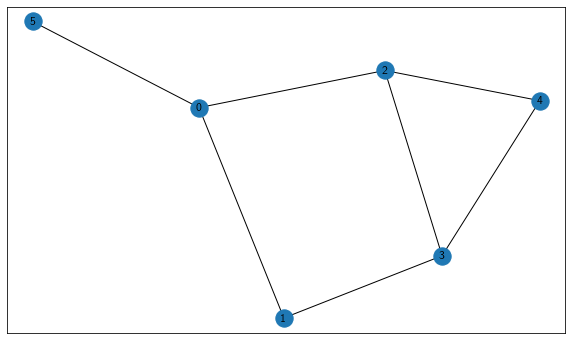

In [4]:
V = np.arange(0,6,1)
E =[(0,1,1),(0,2,1),(2,3,1),(3,1,1),(3,4,1),(4,2,1),(0,5,1)]
G = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

pos = nx.spring_layout(G)
pl.figure(figsize=(10,6))
nx.draw_networkx(G,apos=pos)

In [5]:
(gamma_min,gamma_max),(beta_min,beta_max) = parameterBounds_MaxCut(G,decimals=0)
gamma_period = (gamma_max-gamma_min)*2
beta_period = beta_max-beta_min

max_weight = max([w for _,_,w in G.edges.data('weight',default=1)])
landscape_n_gamma = 2*int(LANDSCAPE_NYQ_FREQ*np.ceil(gamma_period*(max_weight/2)/(2*np.pi)))
landscape_n_beta = 2*int(LANDSCAPE_NYQ_FREQ*np.ceil(beta_period/(2*np.pi)))

print('landscape_n_gamma: %d' % landscape_n_gamma)
print('landscape_n_beta: %d' % landscape_n_beta)
print('gamma_period: %.2f * 2 pi' % (gamma_period/(2*np.pi)))
print('beta_period: %.2f * pi / 2' % (beta_period/(np.pi/2)))

gammas_landscape = np.linspace(-gamma_period,gamma_period,landscape_n_gamma)
betas_landscape = np.linspace(-beta_period,beta_period,landscape_n_beta)

E_landscape = sample_landscape(G,gammas_landscape,betas_landscape,landscape_n_gamma,landscape_n_beta)

landscape_n_gamma: 64
landscape_n_beta: 64
gamma_period: 1.00 * 2 pi
beta_period: 1.00 * pi / 2


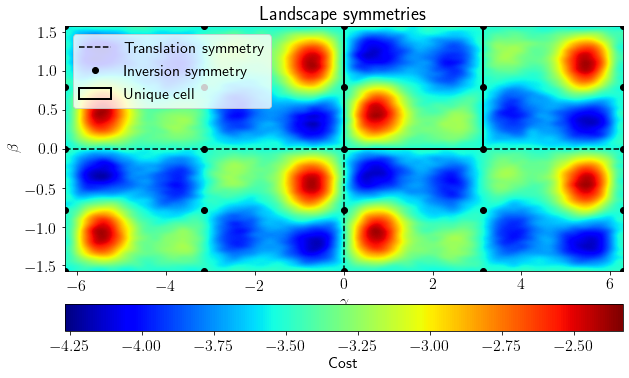

In [6]:
pl.figure(figsize=(10, 6))
plot_landscape_symmetries(G,E_landscape,gammas_landscape,betas_landscape,
                         landscape_n_gamma,gamma_min,gamma_max,gamma_period,
                         landscape_n_beta,beta_min,beta_max,beta_period)

We see that the code finds the correct unique cell.

The next test case is an integer-weighted graph.

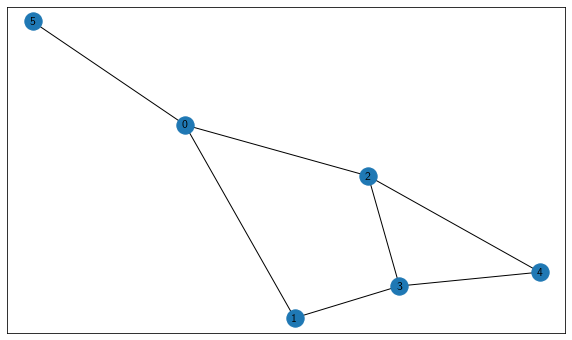

In [7]:
V = np.arange(0,6,1)
E =[(0,1,1),(0,2,2),(2,3,5),(3,1,7),(3,4,3),(4,2,1),(0,5,2)]
G = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

pos = nx.spring_layout(G)
pl.figure(figsize=(10,6))
nx.draw_networkx(G,apos=pos)

In [8]:
(gamma_min,gamma_max),(beta_min,beta_max) = parameterBounds_MaxCut(G,decimals=0)
gamma_period = (gamma_max-gamma_min)*2
beta_period = beta_max-beta_min

max_weight = max([w for _,_,w in G.edges.data('weight',default=1)])
landscape_n_gamma = 2*int(LANDSCAPE_NYQ_FREQ*np.ceil(gamma_period*(max_weight/2)/(2*np.pi)))
landscape_n_beta = 2*int(LANDSCAPE_NYQ_FREQ*np.ceil(beta_period/(2*np.pi)))

print('landscape_n_gamma: %d' % landscape_n_gamma)
print('landscape_n_beta: %d' % landscape_n_beta)
print('gamma_period: %.2f * 2 pi' % (gamma_period/(2*np.pi)))
print('beta_period: %.2f * pi / 2' % (beta_period/(np.pi/2)))

gammas_landscape = np.linspace(-gamma_period,gamma_period,landscape_n_gamma)
betas_landscape = np.linspace(-beta_period,beta_period,landscape_n_beta)

E_landscape = sample_landscape(G,gammas_landscape,betas_landscape,landscape_n_gamma,landscape_n_beta)

landscape_n_gamma: 256
landscape_n_beta: 64
gamma_period: 1.00 * 2 pi
beta_period: 1.00 * pi / 2


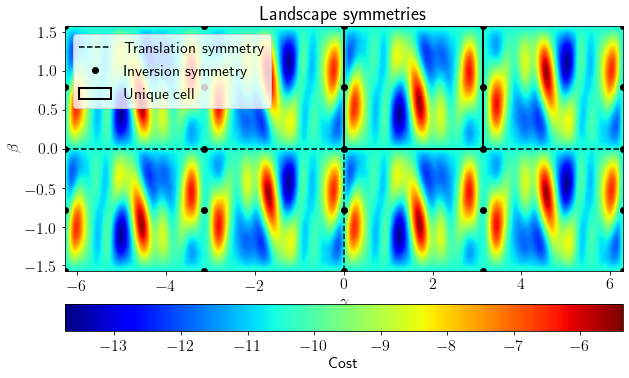

In [9]:
pl.figure(figsize=(10, 6))
plot_landscape_symmetries(G,E_landscape,gammas_landscape,betas_landscape,
                         landscape_n_gamma,gamma_min,gamma_max,gamma_period,
                         landscape_n_beta,beta_min,beta_max,beta_period)

Some thought will reveal that the unique cell for an integer-weighted graph is the same as for the unweighted graph.

Finally, we demonstrate how we handle 2-decimal-weighted graphs.

Weight: 0.4200000000
Weight: 0.4300000000
Weight: 0.6400000000
Weight: 0.0600000000
Weight: 0.1400000000
Weight: 0.7300000000
Weight: 0.5100000000


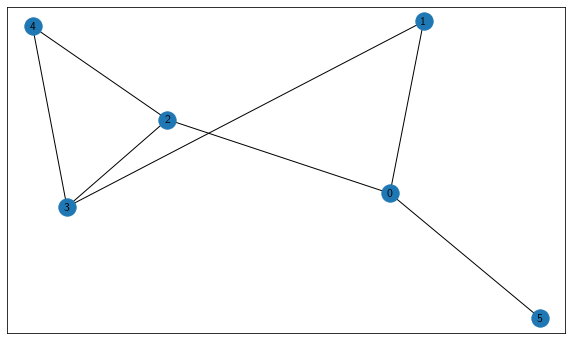

In [10]:
V = np.arange(0,6,1)
G = nx.Graph()
G.add_nodes_from(V)

decimals = 2
E = [(0,1),(0,2),(2,3),(3,1),(3,4),(4,2),(0,5)]
for i,j in E:
    w = round(np.random.uniform(),decimals)
    print('Weight: %.10f' % w)
    G.add_edge(i,j,weight=w)

pos = nx.spring_layout(G)
pl.figure(figsize=(10,6))
nx.draw_networkx(G,apos=pos)

In [11]:
(gamma_min,gamma_max),(beta_min,beta_max) = parameterBounds_MaxCut(G,decimals=decimals)
gamma_period = (gamma_max-gamma_min)*2
beta_period = beta_max-beta_min

max_weight = max([w for _,_,w in G.edges.data('weight',default=1)])
landscape_n_gamma = 2*int(LANDSCAPE_NYQ_FREQ*np.ceil(gamma_period*(max_weight/2)/(2*np.pi)))
landscape_n_beta = 2*int(LANDSCAPE_NYQ_FREQ*np.ceil(beta_period/(2*np.pi)))

print('landscape_n_gamma: %d' % landscape_n_gamma)
print('landscape_n_beta: %d' % landscape_n_beta)
print('gamma_period: %.2f * 2 pi' % (gamma_period/(2*np.pi)))
print('beta_period: %.2f * pi / 2' % (beta_period/(np.pi/2)))

gammas_landscape = np.linspace(-gamma_period,gamma_period,landscape_n_gamma)
betas_landscape = np.linspace(-beta_period,beta_period,landscape_n_beta)

E_landscape = sample_landscape(G,gammas_landscape,betas_landscape,landscape_n_gamma,landscape_n_beta)

landscape_n_gamma: 2624
landscape_n_beta: 64
gamma_period: 100.00 * 2 pi
beta_period: 1.00 * pi / 2


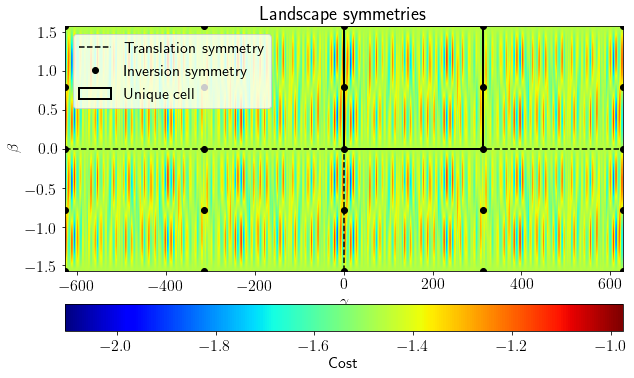

In [12]:
pl.figure(figsize=(10, 6))
plot_landscape_symmetries(G,E_landscape,gammas_landscape,betas_landscape,
                         landscape_n_gamma,gamma_min,gamma_max,gamma_period,
                         landscape_n_beta,beta_min,beta_max,beta_period)